Imports and whatnot (a lot of them are not being used, but they are there for convenience)

In [1]:
import codecs
import json
import os
import re
import sys
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry_convert as pc
import requests
import wikipedia
import wikipediaapi
from alive_progress import alive_bar
from aquarel import load_theme
from bs4 import BeautifulSoup


To get the taxonomic categories, we query wikipedia to get .html's for the birds in the table. We then use beautiful soup to aquire the taxa from the pages. I've done this locally having not to query wikipedia constantly.

In [41]:

def setFolders(lang: str) -> None:
    current_dir = os.getcwd()
    jsonFilename = "not_found.json"
    queryResultsCSVFilename = f"queryResults_{lang}.csv"
    queryResultsCSV = os.path.join(current_dir, queryResultsCSVFilename)
    htmlFolderPath = os.path.join(current_dir, f"html_{lang}")
    htmlNotFoundFolderPath = os.path.join(htmlFolderPath, "404")
    htmlNotFoundJson = os.path.join(htmlNotFoundFolderPath, jsonFilename)
    if not os.path.exists(htmlFolderPath):
        os.makedirs(f"html_{lang}")
    if not os.path.exists(htmlNotFoundFolderPath):
        os.makedirs(htmlNotFoundFolderPath)
    if not os.path.isfile(htmlNotFoundJson):
        queryResults = pd.DataFrame(columns=["Scientific name", "Success"])
        with open(htmlNotFoundJson, "w") as f:
            f.write(queryResults.to_json(orient="records", lines=True))
    if not os.path.isfile(queryResultsCSV):
        queryResults = pd.DataFrame(columns=["Scientific name", "Success", "lang"])
        queryResults.to_csv(queryResultsCSVFilename, index=False)

def get_HTML_wiki(species_name: str, lang: str = "en") -> requests.Response:
    species_name_with_underscores = species_name.replace(" ", "_")
    query = (
        f"https://{lang}.wikipedia.org/api/rest_v1/page/summary/"
        + species_name_with_underscores
    )
    response = requests.get(url=query)
    wiki_title_of_species = response.json()["title"]
    query_wiki_title_of_species = wiki_title_of_species.replace(" ", "_")
    response = requests.get(
        url=f"https://{lang}.wikipedia.org/wiki/" + query_wiki_title_of_species
    )
    return response


def setHtmls(fname: str = "lintudata.csv", lang: str = "en", reset: bool = False) -> None:
    current_dir = os.getcwd()
    jsonFilename = "not_found.json"
    htmlFolderPath = os.path.join(current_dir, f"html_{lang}")
    htmlNotFoundFolderPath = os.path.join(htmlFolderPath, "404")
    htmlNotFoundJson = os.path.join(htmlNotFoundFolderPath, jsonFilename)
    queryResultsCSVFilename = f"queryResults_{lang}.csv"
    queryResultsCSV = os.path.join(current_dir, queryResultsCSVFilename)

    setFolders(lang)

    df = getInitialData(fname, reset)
    currently_failed_urls = ["unspecified"]
    species_list = list(
        df[~df["Scientific name"].isin(currently_failed_urls)]["Scientific name"]
    )

    # dfQueryResults = notFoundJSONToDf(htmlNotFoundJson)
    dfQueryResults = pd.DataFrame(
        columns=["Scientific name", "Success", "lang", f"{lang}_Success"]
    )

    with alive_bar(len(species_list)) as bar:
        for species_name in species_list:
            bar()
            response = get_HTML_wiki(species_name, lang)
            species_name_with_underscores = species_name.replace(" ", "_")
            if not response.ok:
                speciesNotFoundHTMLPath = os.path.join(
                    htmlNotFoundFolderPath, species_name_with_underscores + ".html"
                )
                queryResults = {
                    "Scientific name": species_name,
                    "Success": 0,
                    "lang": lang,
                    f"{lang}_Success": 0,
                }
                dfQueryResults = pd.concat(
                    [dfQueryResults, pd.DataFrame([queryResults])], ignore_index=True
                )

                if os.path.isfile(speciesNotFoundHTMLPath):
                    continue

                with open(speciesNotFoundHTMLPath, "wb+") as f:
                    f.write(response.content)
                continue

            speciesHTMLPath = os.path.join(
                htmlFolderPath, species_name_with_underscores + ".html"
            )
            queryResults = {
                "Scientific name": species_name,
                "Success": 1,
                "lang": lang,
                f"{lang}_Success": 1,
            }
            dfQueryResults = pd.concat(
                [dfQueryResults, pd.DataFrame([queryResults])], ignore_index=True
            )
            if os.path.isfile(speciesHTMLPath):
                continue
            with open(speciesHTMLPath, "wb+") as f:
                f.write(response.content)

        dfQueryResults.to_csv(queryResultsCSV)



In [40]:
setHtmls("lintudata.csv",lang="en", reset = False)

|█████████▋⚠︎                             | (!) 29/121 [24%] in 8.6s (3.38/s) 


KeyboardInterrupt: 

Loading the "List of national birds" file from wikipedia, or getting it from pre-existing file (default name is "lintudata.csv"), which is the "base" for the final csv, which will be used for charts and whatnot.

In [49]:
def map_success_to_df(df: pd.DataFrame, lang: str = "en") -> pd.DataFrame:
    try:
        df_success_for_lang = pd.read_csv(f"queryResults_{lang}.csv")
    except (FileNotFoundError, FileExistsError) as e:
        print("Something went wrong getting the file")
        raise (e)
    except Exception as e:
        raise (e)
    df_success_for_lang = df_success_for_lang.drop_duplicates(["Scientific name"])
    mapped_df = pd.merge(
        df, 
        df_success_for_lang[["Scientific name", 
        f"{lang}_Success"]], 
        on="Scientific name", how="right"
        )
    return mapped_df
def getInitialData(fname: str = "lintudata.csv", reset: bool = False) -> pd.DataFrame:

    not_found_dict = {
        "Eupsittula pertinax arubensis": "Eupsittula pertinax",
        "Pica (pica) serica": "Pica serica",
        "Pica (pica) serieca": "Pica serica",
    }
    currently_failed_urls = ["unspecified"]

    if (not (os.path.isfile(fname))) or reset:
        url = "https://en.wikipedia.org/wiki/List_of_national_birds"
        tables = pd.read_html(url)
        df = tables[0]
        df.replace({"Scientific name": not_found_dict}, inplace=True)
        df = df[~df["Scientific name"].isin(currently_failed_urls)]
        df.to_csv(fname)
    else:
        df = pd.read_csv(fname)
    return df


In [50]:

df1  = getInitialData(reset=True)
df1 = map_success_to_df(df1, lang="en" )
display(df1)

,Country,Name of bird,Scientific name,Official status,Picture,Ref.,en_Success
0,Afghanistan,Golden eagle,Aquila chrysaetos,Yes,NaN,[1][2],1
1,Albania,Golden eagle,Aquila chrysaetos,Yes,NaN,[3][4],1
2,Germany,Golden eagle,Aquila chrysaetos,No,NaN,[48],1
3,Mexico,Golden eagle,Aquila chrysaetos,Yes,NaN,[73],1
4,Romania,Golden eagle,Aquila chrysaetos,Yes,NaN,[101][102],1
...,...,...,...,...,...,...,...
116,United Kingdom,European robin,Erithacus rubecula,No,NaN,[122][123],1
117,United States,Bald eagle,Haliaeetus leucocephalus,Yes,NaN,[124][125],1
118,Uruguay,Southern lapwing,Vanellus chilensis,No,NaN,[126],1
119,Venezuela,Venezuelan troupial,Icterus icterus,Yes,NaN,[127],1


We then get the taxa from the downloaded htmls using the functions below:

In [38]:
def get_Biological_categories_local(
    species_name: str, b_keyword: str = "Order", lang: str = "en"
) -> str:
    species_name_underline = species_name.replace(" ", "_")
    with open(f"html_{lang}/" + species_name_underline + ".html") as fp:
        soup = BeautifulSoup(fp, "html.parser")
    found = False
    if lang == "fi":
        table = soup.find("table", {"class": "infobox"})
    if lang == "en":
        table = soup.find("table", {"class": "infobox biota"})
    regexp = re.compile(rf"{b_keyword}")
    rows = table.find_all("tr")
    for row in rows:
        cells = row.find_all(["td"], recursive=False)
        for cell in cells:
            if cell.string:
                # print(cell)
                m = re.search(rf".?({b_keyword}).?", str(cell))
                if m is not None:
                    found = True
        if found:
            # print(row)
            m = re.search(r">(\w*)</(?:a|b)>", str(row))
            try:
                match = m.group(1)
                return match
            except Exception:
                print("#### ", species_name, " was not found")
                raise
            found = False
    return
def setBiologicalCategoryToColumn(
    df: pd.DataFrame, b_keyword: str, lang: str = "en"
) -> pd.DataFrame:
    return df.apply(
        lambda row: (
            get_Biological_categories_local(
                row["Scientific name"], b_keyword, lang=lang
            )
            if row[lang + "_Success"] == 1
            else pd.NA
        ),
        axis=1,
    )



In [52]:
df1["Order"] = setBiologicalCategoryToColumn(df1, "Order", lang="en")
df1["Family"] = setBiologicalCategoryToColumn(df1, "Family", lang="en")
display(df1)

,Country,Name of bird,Scientific name,Official status,Picture,Ref.,en_Success,Order,Family
0,Afghanistan,Golden eagle,Aquila chrysaetos,Yes,NaN,[1][2],1,Accipitriformes,Accipitridae
1,Albania,Golden eagle,Aquila chrysaetos,Yes,NaN,[3][4],1,Accipitriformes,Accipitridae
2,Germany,Golden eagle,Aquila chrysaetos,No,NaN,[48],1,Accipitriformes,Accipitridae
3,Mexico,Golden eagle,Aquila chrysaetos,Yes,NaN,[73],1,Accipitriformes,Accipitridae
4,Romania,Golden eagle,Aquila chrysaetos,Yes,NaN,[101][102],1,Accipitriformes,Accipitridae
...,...,...,...,...,...,...,...,...,...
116,United Kingdom,European robin,Erithacus rubecula,No,NaN,[122][123],1,Passeriformes,Muscicapidae
117,United States,Bald eagle,Haliaeetus leucocephalus,Yes,NaN,[124][125],1,Accipitriformes,Accipitridae
118,Uruguay,Southern lapwing,Vanellus chilensis,No,NaN,[126],1,Charadriiformes,Charadriidae
119,Venezuela,Venezuelan troupial,Icterus icterus,Yes,NaN,[127],1,Passeriformes,Icteridae


Using wikipedia to set finnish translation to column

In [13]:
def getCountryTranslationsWiki(
    df: pd.DataFrame, reset: bool = False, fname: str = "country_translations.json"
) -> pd.DataFrame:
    """
    English -> finnish translation for the country names.
    Uses wikipedia lllang links to query english wikipedia page for
    a given country and returns the respective finnish site title.
    Saves it to a .json, and returns it.
    """

    if not reset:
        try:
            df_from_json = pd.read_json(fname)
            return df_from_json
        except Exception:
            print("Something failed")
            return pd.DataFrame([])

    assert "Country" in df, "Couldnt find country in the dataframe"
    json_list = []
    with alive_bar(len(df["Country"])) as bar:
        for i in df["Country"]:
            bar()
            S = requests.Session()

            URL = "https://en.wikipedia.org/w/api.php"

            PARAMS = {
                "action": "query",
                "prop": "langlinks",
                "format": "json",
                "lllang": "fi",
                "titles": i,
            }

            R = S.get(url=URL, params=PARAMS)
            DATA = R.json()

            for page in DATA["query"]["pages"].values():
                langlinks = page.get("langlinks", [])
                try:
                    print(langlinks, i)
                    # print(i, " ja suomennos: ", langlinks[0]["*"])
                    fin = page["langlinks"][0]["*"]
                    # print(fin)
                    #
                    #

                except Exception:
                    print("Something happened")
                    dd = {"Palestine": "Palestiina", "Bahamas": "Bahama"}
                    fin = dd[page["title"]]
                data_for_country = {
                    "Country": i,
                    "Maa": fin,
                }
                # print("HERE", data_for_country)
                json_list.append(data_for_country)
        jsondf = pd.DataFrame.from_dict(json_list)
        jsondf.to_json(fname)

        return jsondf


def mapWikipediaTranslationsToMainDataframeCountries(
    df: pd.DataFrame, fname: str = "test_country_trans.json"
) -> pd.DataFrame:

    country_translations = getCountryTranslationsWiki(
        df, reset=False, fname="test_country_trans.json"
    )
    country_translations = country_translations.drop_duplicates(["Maa", "Country"])
    print(country_translations)
    mapped_df = pd.merge(
        df, country_translations[["Maa", "Country"]], on=["Country"], how="right"
    )
    return mapped_df


In [22]:
df1 = mapWikipediaTranslationsToMainDataframeCountries(df1)
display(df1)

                   Country                   Maa
0              Afghanistan            Afganistan
1                  Albania               Albania
2                    Egypt                Egypti
3                  Germany                 Saksa
4                Indonesia             Indonesia
..                     ...                   ...
114              Singapore             Singapore
115       Papua New Guinea     Papua-Uusi-Guinea
116               Paraguay              Paraguay
117            Puerto Rico           Puerto Rico
119  Saint Kitts and Nevis  Saint Kitts ja Nevis

[115 rows x 2 columns]


,Country,Name of bird,Scientific name,Official status,Picture,Ref.,Maa
0,Afghanistan,Golden eagle,Aquila chrysaetos,Yes,NaN,[1][2],Afganistan
1,Albania,Golden eagle,Aquila chrysaetos,Yes,NaN,[3][4],Albania
2,Egypt,Steppe eagle,Aquila nipalensis,Yes,NaN,[41],Egypti
3,Germany,Golden eagle,Aquila chrysaetos,No,NaN,[48],Saksa
4,Indonesia,Javan hawk-eagle,Nisaetus bartelsi,Yes,NaN,[58],Indonesia
...,...,...,...,...,...,...,...
116,Singapore,Crimson sunbird,Aethopyga siparaja,No,NaN,[111],Singapore
117,Papua New Guinea,Raggiana bird-of-paradise,Paradisaea raggiana,Yes,NaN,[93],Papua-Uusi-Guinea
118,Paraguay,Bare-throated bellbird,Procnias nudicollis,Yes,NaN,[94],Paraguay
119,Puerto Rico,Puerto Rican spindalis,Spindalis portoricensis,No,NaN,[99][100],Puerto Rico


After, we get the translations for species

In [24]:
def mapWikipediaTranslationsToMainDataframeSpecies(
    df: pd.DataFrame,
    reset: bool = False,
    fname: str = "species_trans.csv",
) -> pd.DataFrame:
    species_translations = getWikiTranslationsForSpecies(df, reset, fname)

    species_translations = species_translations.drop_duplicates(
        ["Scientific name", "fi_Species_name"]
    )
    mapped_df = pd.merge(
        df,
        species_translations[["Scientific name", "fi_Species_name"]],
        on="Scientific name",
        how="right",
    )

    return mapped_df


def getWikiTranslationsForSpecies(
    df: pd.DataFrame, reset: bool = False, fname: str = "species_trans.csv"
) -> pd.DataFrame:
    """
    Queries the finnish wikipedia with scientific name.
    Inserts the result to a new column called fi_Species_name.
    Couple of species name werent found by quering,
    so there is a manual dict for them.
    """

    if not reset:
        try:
            df_from_file = pd.read_csv(fname)
            return df_from_file
        except (FileNotFoundError, FileExistsError):
            print("Something went wrong finding the file")
        except Exception as e:
            raise (e)
    wikiTranslations = []
    failure_dict = {
        "Cinnyris oseus": "Cinnyris osea",
    }
    with alive_bar(len(df["Scientific name"])) as bar:
        for s in df["Scientific name"]:
            bar()
            try:
                wikipedia.set_lang("fi")
                fi_Species_name = wikipedia.search(s)[0]
                print(fi_Species_name)
                wikiTranslations.append(
                    {
                        "Scientific name": s,
                        "fi_Species_name": fi_Species_name,
                    }
                )
            except Exception:
                print("Failure with species: ", s)
                wikiTranslations.append({"Scientific name": s, "fi_Species_name": "0"})
                pass
    failed_translations_found_somewhere_else = {
        "Ptilinopus pelewensis": "Palaunhedelmäkyyhky",
        "Lophophorus impejanus": "Töyhtöloistofasaani",
        "Cinnyris oseus": "Isopurppuramedestäjä",
        
    }
    species_translations = pd.DataFrame(wikiTranslations)
    species_translations["fi_Species_name"] = (
        species_translations["Scientific name"]
        .map(failed_translations_found_somewhere_else)
        .fillna(species_translations["fi_Species_name"])
    )
    species_translations.to_csv(fname)
    return species_translations



In [53]:
df1 = mapWikipediaTranslationsToMainDataframeSpecies(df1)
display(df1)

,Country,Name of bird,Scientific name,Official status,Picture,Ref.,en_Success,Order,Family,fi_Species_name
0,Afghanistan,Golden eagle,Aquila chrysaetos,Yes,NaN,[1][2],1,Accipitriformes,Accipitridae,Maakotka
1,Albania,Golden eagle,Aquila chrysaetos,Yes,NaN,[3][4],1,Accipitriformes,Accipitridae,Maakotka
2,Germany,Golden eagle,Aquila chrysaetos,No,NaN,[48],1,Accipitriformes,Accipitridae,Maakotka
3,Mexico,Golden eagle,Aquila chrysaetos,Yes,NaN,[73],1,Accipitriformes,Accipitridae,Maakotka
4,Romania,Golden eagle,Aquila chrysaetos,Yes,NaN,[101][102],1,Accipitriformes,Accipitridae,Maakotka
...,...,...,...,...,...,...,...,...,...,...
116,Singapore,Crimson sunbird,Aethopyga siparaja,No,NaN,[111],1,Passeriformes,Nectariniidae,Karmiinimedestäjä
117,Papua New Guinea,Raggiana bird-of-paradise,Paradisaea raggiana,Yes,NaN,[93],1,Passeriformes,Paradisaeidae,Kuningasparatiisilintu
118,Paraguay,Bare-throated bellbird,Procnias nudicollis,Yes,NaN,[94],1,Passeriformes,Cotingidae,Etelänseppäkotinga
119,Puerto Rico,Puerto Rican spindalis,Spindalis portoricensis,No,NaN,[99][100],1,Passeriformes,Spindalidae,Hispaniolantangarat


Set continents and countries, both translated. After initialization, the json is saved to the folder to skip time consuming querying.

In [59]:
def country_to_continent(country_name):
    notFoundDict = {
        "Northern Ireland": "Europe",
        "Saint Helena": "Africa",
        "Scotland": "Europe",
        "Wales": "Europe",
    }
    try:
        # print(country_name)
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    except KeyError:
        return notFoundDict[country_name]
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(
        country_continent_code
    )
    return country_continent_name
def continentToMaanosa(continent: str) -> str:
    continentDict = {
        "Asia": "Aasia",
        "Europe": "Eurooppa",
        "South America": "Etelä-Amerikka",
        "North America": "Pohjois-Amerikka",
        "Africa": "Afrikka",
        "Oceania": "Oseania",
    }

    return continentDict[continent]

def getCountryTranslationsWiki(
    df: pd.DataFrame, reset: bool = False, fname: str = "country_translations.json"
) -> pd.DataFrame:
    """
    English -> finnish translation for the country names.
    Uses wikipedia lllang links to query english wikipedia page for
    a given country and returns the respective finnish site title.
    Saves it to a .json, and returns it.
    """

    if not reset:
        try:
            df_from_json = pd.read_json(fname)
            return df_from_json
        except Exception:
            print("Something failed")
            return pd.DataFrame([])

    assert "Country" in df, "Couldnt find country in the dataframe"
    json_list = []
    with alive_bar(len(df["Country"])) as bar:
        for i in df["Country"]:
            bar()
            S = requests.Session()

            URL = "https://en.wikipedia.org/w/api.php"

            PARAMS = {
                "action": "query",
                "prop": "langlinks",
                "format": "json",
                "lllang": "fi",
                "titles": i,
            }

            R = S.get(url=URL, params=PARAMS)
            DATA = R.json()

            for page in DATA["query"]["pages"].values():
                langlinks = page.get("langlinks", [])
                try:
                    print(langlinks, i)
                    # print(i, " ja suomennos: ", langlinks[0]["*"])
                    fin = page["langlinks"][0]["*"]
                    # print(fin)
                    #
                    #

                except Exception:
                    print("Something happened")
                    dd = {"Palestine": "Palestiina", "Bahamas": "Bahama"}
                    fin = dd[page["title"]]
                data_for_country = {
                    "Country": i,
                    "Maa": fin,
                }
                # print("HERE", data_for_country)
                json_list.append(data_for_country)
        jsondf = pd.DataFrame.from_dict(json_list)
        jsondf.to_json(fname)

        return jsondf
        # write_json(json_list, fname)
        # return jsondf
def mapWikipediaTranslationsToMainDataframeCountries(
    df: pd.DataFrame, fname: str = "test_country_trans.json", reset: bool = False
) -> pd.DataFrame:

    country_translations = getCountryTranslationsWiki(
        df, reset, fname
    )
    country_translations = country_translations.drop_duplicates(["Maa", "Country"])
    print(country_translations)
    mapped_df = pd.merge(
        df, country_translations[["Maa", "Country"]], on=["Country"], how="right"
    )
    return mapped_df

In [60]:
df1["Continent"] = df1["Country"].apply(country_to_continent)
df1["Maanosa"] = df1["Continent"].apply(continentToMaanosa)
df1 = mapWikipediaTranslationsToMainDataframeCountries(df1, reset=True)
display(df1)

on 1: [{'lang': 'fi', '*': 'Afganistan'}] Afghanistan
on 1: HERE {'Country': 'Afghanistan', 'Maa': 'Afganistan'}
on 2: [{'lang': 'fi', '*': 'Albania'}] Albania
on 2: HERE {'Country': 'Albania', 'Maa': 'Albania'}
on 3: [{'lang': 'fi', '*': 'Saksa'}] Germany
on 3: HERE {'Country': 'Germany', 'Maa': 'Saksa'}
on 4: [{'lang': 'fi', '*': 'Meksiko'}] Mexico
on 4: HERE {'Country': 'Mexico', 'Maa': 'Meksiko'}
on 5: [{'lang': 'fi', '*': 'Romania'}] Romania
on 5: HERE {'Country': 'Romania', 'Maa': 'Romania'}
on 6: [{'lang': 'fi', '*': 'Skotlanti'}] Scotland
on 6: HERE {'Country': 'Scotland', 'Maa': 'Skotlanti'}
on 7: [{'lang': 'fi', '*': 'Egypti'}] Egypt
on 7: HERE {'Country': 'Egypt', 'Maa': 'Egypti'}
on 8: [{'lang': 'fi', '*': 'Indonesia'}] Indonesia
on 8: HERE {'Country': 'Indonesia', 'Maa': 'Indonesia'}
on 9: [{'lang': 'fi', '*': 'Namibia'}] Namibia
on 9: HERE {'Country': 'Namibia', 'Maa': 'Namibia'}
on 10: [{'lang': 'fi', '*': 'Sambia'}] Zambia
on 10: HERE {'Country': 'Zambia', 'Maa': 'Sambi

,Country,Name of bird,Scientific name,Official status,Picture,Ref.,en_Success,Order,Family,fi_Species_name,Continent,Maanosa,Maa
0,Afghanistan,Golden eagle,Aquila chrysaetos,Yes,NaN,[1][2],1,Accipitriformes,Accipitridae,Maakotka,Asia,Aasia,Afganistan
1,Albania,Golden eagle,Aquila chrysaetos,Yes,NaN,[3][4],1,Accipitriformes,Accipitridae,Maakotka,Europe,Eurooppa,Albania
2,Germany,Golden eagle,Aquila chrysaetos,No,NaN,[48],1,Accipitriformes,Accipitridae,Maakotka,Europe,Eurooppa,Saksa
3,Mexico,Golden eagle,Aquila chrysaetos,Yes,NaN,[73],1,Accipitriformes,Accipitridae,Maakotka,North America,Pohjois-Amerikka,Meksiko
4,Romania,Golden eagle,Aquila chrysaetos,Yes,NaN,[101][102],1,Accipitriformes,Accipitridae,Maakotka,Europe,Eurooppa,Romania
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Singapore,Crimson sunbird,Aethopyga siparaja,No,NaN,[111],1,Passeriformes,Nectariniidae,Karmiinimedestäjä,Asia,Aasia,Singapore
117,Papua New Guinea,Raggiana bird-of-paradise,Paradisaea raggiana,Yes,NaN,[93],1,Passeriformes,Paradisaeidae,Kuningasparatiisilintu,Oceania,Oseania,Papua-Uusi-Guinea
118,Paraguay,Bare-throated bellbird,Procnias nudicollis,Yes,NaN,[94],1,Passeriformes,Cotingidae,Etelänseppäkotinga,South America,Etelä-Amerikka,Paraguay
119,Puerto Rico,Puerto Rican spindalis,Spindalis portoricensis,No,NaN,[99][100],1,Passeriformes,Spindalidae,Hispaniolantangarat,North America,Pohjois-Amerikka,Puerto Rico


Add the finnish translations of the taxonomic categories to the df

In [62]:
def mapWikipediaTranslationsToMainDataframeTaxa(
    df: pd.DataFrame, reset: bool = False, fname: str = "testTrans.csv"
) -> pd.DataFrame:
    """
    Set the wikipedia translations to an existing dataframe.
    Returns the result as a merged df.
    """
    wikiTranslations = getWikiTranslationsForTaxa(df, reset, fname)
    wikiTranslations = wikiTranslations.drop_duplicates(subset=["Order", "Family"])
    mappedDf = pd.merge(
        df,
        wikiTranslations[["Order", "Family", "fi_family", "fi_order"]],
        on=["Order", "Family"],
        how="right",
    )
    return mappedDf
def getWikiTranslationsForTaxa(
    df: pd.DataFrame, reset: bool = False, fname: str = "testTrans.csv"
) -> pd.DataFrame:
    """
    Set the biologial categories Order and Family to a csv,
    translated by wikipedia.
    Columns are set to fi_order and fi_family respectively
    """
    assert (
        "Order" in df and "Family" in df
    ), "Either order or family doesnt exist in the given df"
    if not reset:
        try:
            return pd.read_csv(fname)
        except (FileExistsError, FileNotFoundError):
            print("File wasnt found, make sure youve initialized the translations")
            print("Setting the file with default parameters")
    wikiTranslations = []
    with alive_bar(len(df["Order"])) as bar:
        for o, f in zip(df["Order"], df["Family"]):
            bar()
            try:
                wikipedia.set_lang("fi")
                fi_order = wikipedia.search(o)[0]
                fi_family = wikipedia.search(f)[0]
                print(fi_order, fi_family)
                wikiTranslations.append(
                    {
                        "Order": o,
                        "Family": f,
                        "fi_family": fi_family,
                        "fi_order": fi_order,
                    }
                )
            except Exception:
                print("Failure")
                pass
    wikiTranslationsOrderDf = pd.DataFrame(wikiTranslations)
    wikiTranslationsOrderDf.to_csv(fname)

    return wikiTranslationsOrderDf




In [64]:
df1 = mapWikipediaTranslationsToMainDataframeTaxa(df1, reset=True)
display(df1) 

on 1: Petolinnut Haukat
on 2: Petolinnut Haukat
on 3: Petolinnut Haukat
on 4: Petolinnut Haukat
on 5: Petolinnut Haukat
on 6: Pelikaanilinnut Pelikaanit
on 7: Petolinnut Haukat
on 8: Petolinnut Haukat
on 9: Petolinnut Haukat
on 10: Petolinnut Haukat
on 11: Petolinnut Haukat
on 12: Petolinnut Haukat
on 13: Petolinnut Haukat
on 14: Petolinnut Haukat
on 15: Petolinnut Haukat
on 16: Petolinnut Haukat
on 17: Haikaralinnut Kattohaikarat
on 18: Haikaralinnut Kattohaikarat
on 19: Haikaralinnut Kattohaikarat
on 20: Haikaralinnut Kattohaikarat
on 21: Petolinnut Haukat
on 22: Petolinnut Haukat
on 23: Petolinnut Haukat
on 24: Turakot Turakot
on 25: Turakot Turakot
on 26: Kyyhkylinnut Kyyhkyt
on 27: Kyyhkylinnut Kyyhkyt
on 28: Kyyhkylinnut Kyyhkyt
on 29: Kyyhkylinnut Kyyhkyt
on 30: Suliformes Fregattilinnut
on 31: Varpuslinnut Orneerot
on 32: Papukaijalinnut Papukaijat
on 33: Pöllölinnut Pöllöt
on 34: Papukaijalinnut Papukaijat
on 35: Papukaijalinnut Papukaijat
on 36: Papukaijalinnut Papukaijat
on 

,Country,Name of bird,Scientific name,Official status,Picture,Ref.,en_Success,Order,Family,fi_Species_name,Continent,Maanosa,Maa,fi_family,fi_order
0,Afghanistan,Golden eagle,Aquila chrysaetos,Yes,NaN,[1][2],1,Accipitriformes,Accipitridae,Maakotka,Asia,Aasia,Afganistan,Haukat,Petolinnut
1,Albania,Golden eagle,Aquila chrysaetos,Yes,NaN,[3][4],1,Accipitriformes,Accipitridae,Maakotka,Europe,Eurooppa,Albania,Haukat,Petolinnut
2,Germany,Golden eagle,Aquila chrysaetos,No,NaN,[48],1,Accipitriformes,Accipitridae,Maakotka,Europe,Eurooppa,Saksa,Haukat,Petolinnut
3,Mexico,Golden eagle,Aquila chrysaetos,Yes,NaN,[73],1,Accipitriformes,Accipitridae,Maakotka,North America,Pohjois-Amerikka,Meksiko,Haukat,Petolinnut
4,Romania,Golden eagle,Aquila chrysaetos,Yes,NaN,[101][102],1,Accipitriformes,Accipitridae,Maakotka,Europe,Eurooppa,Romania,Haukat,Petolinnut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Palestine,Palestine sunbird,Cinnyris oseus,No,NaN,[91],1,Passeriformes,Nectariniidae,Isopurppuramedestäjä,Asia,Aasia,Palestiina (valtio),Medestäjät,Varpuslinnut
117,Singapore,Crimson sunbird,Aethopyga siparaja,No,NaN,[111],1,Passeriformes,Nectariniidae,Karmiinimedestäjä,Asia,Aasia,Singapore,Medestäjät,Varpuslinnut
118,Papua New Guinea,Raggiana bird-of-paradise,Paradisaea raggiana,Yes,NaN,[93],1,Passeriformes,Paradisaeidae,Kuningasparatiisilintu,Oceania,Oseania,Papua-Uusi-Guinea,Paratiisilinnut,Varpuslinnut
119,Paraguay,Bare-throated bellbird,Procnias nudicollis,Yes,NaN,[94],1,Passeriformes,Cotingidae,Etelänseppäkotinga,South America,Etelä-Amerikka,Paraguay,Kotingat,Varpuslinnut


Saving it for later use, optional

In [66]:

df1.to_csv("lintudata.csv")

In [2]:

df = pd.read_csv("lintudata.csv")

In [20]:

print(df.loc[df["fi_order"]=="Petolinnut"])

    Unnamed: 0        Country            Name of bird  \
0            0    Afghanistan            Golden eagle   
1            1        Albania            Golden eagle   
2            2        Germany            Golden eagle   
3            3         Mexico            Golden eagle   
4            4        Romania            Golden eagle   
5            5       Scotland            Golden eagle   
6            6          Egypt            Steppe eagle   
7            7      Indonesia        Javan hawk-eagle   
8            8        Namibia      African fish eagle   
9            9         Zambia      African fish eagle   
10          10       Zimbabwe      African fish eagle   
11          11    North Korea        Northern goshawk   
12          12         Panama             Harpy eagle   
13          13    Philippines        Philippine eagle   
14          14         Poland      White-tailed eagle   
15          15         Serbia  Eastern imperial eagle   
16          16  United States  

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

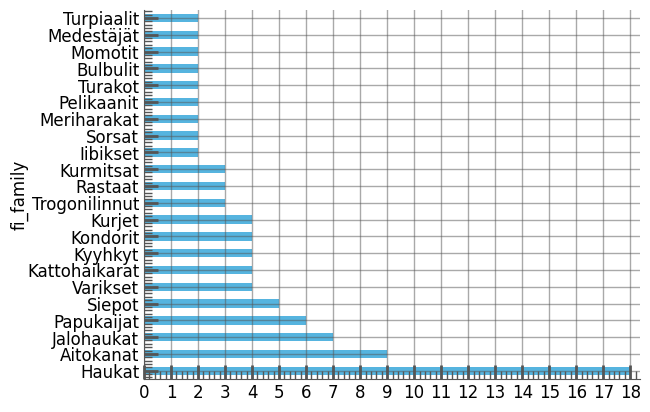

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

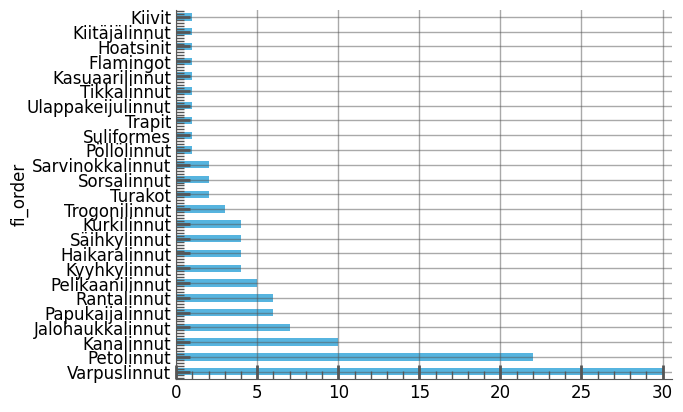

In [8]:
theme = load_theme("scientific").set_grid(width=1)
theme.apply()
# plt.rcParams.update({"font.size": 8})
# plt.rcParams['figure.figsize'] = [10, 8]

plt.figure()
# plt.style.use("seaborn-v0_8-pastel")
# plt.style.use("classic")
# f, axes = plt.subplot(2)
# ax1, ax2, ax3, ax4 = axes.flatten()
locs, labels = plt.yticks()
plt.xticks(np.arange(0, 20, step=1))
df["fi_family"].value_counts().loc[lambda x: x>= 2].plot(kind="barh")

plt.show()
# df["fi_family"].value_counts().loc[lambda x: x< 2].plot(kind="barh")
# f2 = df["fi_family"].value_counts().plot(kind="barh")

df["fi_order"].value_counts().plot(kind="barh")
plt.show()

theme.apply_transforms()

In [ ]:

print(
df["fi_family"].value_counts().loc[lambda x: x<2].value_counts().sum())
#TODO Inaccuraies on the species level (finnish translations), upper taxonomical categories have been good so far.
print(df.loc[df["fi_order"] == "Kanalinnut"][["fi_Species_name", "Country", "Scientific name", "Name of bird"]])
print(df.loc[df["fi_Species_name"] == "Kana"]["Country"])

29
        fi_Species_name              Country            Scientific name  \
56             Vuoripyy             Pakistan           Alectoris chukar   
57                 Kana               France              Gallus gallus   
58            Kalliopyy            Gibraltar          Alectoris barbara   
59          Riikinkukko                India             Pavo cristatus   
60              Fasaani                Japan       Phasianus versicolor   
61        Täpläfasaanit              Myanmar  Polyplectron bicalcaratum   
62  Töyhtöloistofasaani                Nepal      Lophophorus impejanus   
63                 Kana            Sri Lanka           Gallus lafayetii   
64        Hopeafasaanit             Thailand             Lophura diardi   
81   Punaperäkaklattaja  Trinidad and Tobago          Ortalis ruficauda   

             Name of bird  
56       Chukar partridge  
57         Gallic rooster  
58      Barbary partridge  
59         Indian peacock  
60         Green pheasant  
61 

In [109]:

print(df["fi_family"].value_counts().loc[lambda x: x>=2].sum())
print(df["fi_family"].value_counts().loc[lambda x: x==1].sum())
print(df.loc[df["fi_order"] == "Varpuslinnut"]["fi_Species_name"].value_counts().sum())

val_counts = df["fi_Species_name"].value_counts()
val_counts = val_counts[val_counts == 1].index
print(df[df["fi_Species_name"].isin(val_counts)].loc[df["fi_order"] == "Varpuslinnut"]["fi_order"].value_counts())
print(df.loc[df["Country" ]== "Nicaragua"])
# display(df[df["fi_order"] == "Papukaijalinnut"])

92
29
30
fi_order
Varpuslinnut    27
Name: count, dtype: int64
    Unnamed: 0    Country             Name of bird        Scientific name  \
95          95  Nicaragua  Turquoise-browed motmot  Eumomota superciliosa   

   Official status  Picture  Ref.  en_Success          Order     Family  \
95             Yes      NaN  [82]           1  Coraciiformes  Momotidae   

       fi_Species_name      Continent           Maanosa        Maa fi_family  \
95  Mustakurkkumomotti  North America  Pohjois-Amerikka  Nicaragua   Momotit   

        fi_order  
95  Säihkylinnut  
